# Modelo RandomForest & XGBoost

#### Importamos las librerias necesarias

In [4]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cm

# Preprocesado y modelado
# ==============================================================================
import sklearn

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, \
                            mean_squared_error, r2_score, plot_confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample

import category_encoders as ce

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

# Configuración warnings
# ==============================================================================
import warnings

In [5]:
X_train_lasso = pd.read_parquet("X_train_lasso.parquet")
y_train = pd.read_parquet("y_train.parquet")
X_test_lasso = pd.read_parquet("X_test_lasso.parquet")
y_test = pd.read_parquet("y_test.parquet")

## Modelado

In [6]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [12]:
warnings.filterwarnings('ignore')
classifiers = [
    RandomForestClassifier(n_jobs=-1),
    XGBClassifier(n_jobs=-1)
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_lasso, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test_lasso, y_test.values.ravel()))

RandomForestClassifier(n_jobs=-1)
model score: 0.853
[02:33:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=Non

Usamos n_jobs=-1 y n_thread=-1, para utilizar todos los nucleos del ordenador en estos modelos y que el tiempo de computacion sea lo minimo posible. Ponemos GradientBoost en el centro para dejar desacansar al ordenador entre los otros modelos.

In [20]:
rf = Pipeline(steps=[('classifier', RandomForestClassifier())])

Ahora hacemos uso de RandomizedSearchCV para buscar los mejores hiperparametros.

Como hemos tenido que ejecutar 2 veces RandomizedSearchCV para los modelos, usamos una leyenda con los mejores hiperparametros para cada modelo, y los hiperparametros rechazados se encuentran comentados.

In [21]:
# Random Forest parameters to be tuned

# Number of trees in random forest
n_estimators = [400] #100, 200, 250, 300, 500
# Numer of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [10] #4, 5, 6, 7
# Minimum number of samples required to split a node
min_samples_split = [6] #4, 5, 7
# Function to measure the quality of a split.
criterion = ['gini']
# Method of selecting samples for training each 
bootstrap = [False]

In [22]:
random_grid = {'classifier__n_estimators': n_estimators, 
               'classifier__max_features': max_features, 
               'classifier__max_depth': max_depth, 
               'classifier__min_samples_split': min_samples_split,  
               'classifier__bootstrap': bootstrap}

In [16]:
CV = RandomizedSearchCV (estimator = rf, param_distributions = random_grid, 
                         n_iter = 4, cv = 3, verbose = 3, random_state = 0, n_jobs = -1)

CV.fit(X_train_lasso, y_train)
print(CV.best_params_)
print(CV.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'classifier__n_estimators': 400, 'classifier__min_samples_split': 6, 'classifier__max_features': 'auto', 'classifier__max_depth': 10, 'classifier__bootstrap': False}
0.8492462001661275


In [8]:
# Cargamos el modelo para no tener que entrenarlo otra vez

with open('CV_RandomForest.pkl', 'rb') as f:
    CV = pickle.load(f)

In [9]:
CV_predictions = CV.predict(X_test_lasso)

In [10]:
print("Classification report:")
print(classification_report(y_test, CV_predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.92   1440322
           1       0.64      0.23      0.33    288210

    accuracy                           0.85   1728532
   macro avg       0.75      0.60      0.62   1728532
weighted avg       0.83      0.85      0.82   1728532



In [11]:
CV_predict_proba = CV.predict_proba(X_test_lasso)

In [12]:
recall_score(y_test, CV_predictions)

0.2259949342493321

In [13]:
precision_score(y_test, CV_predictions)

0.63756227914762

#### Matriz de confusion

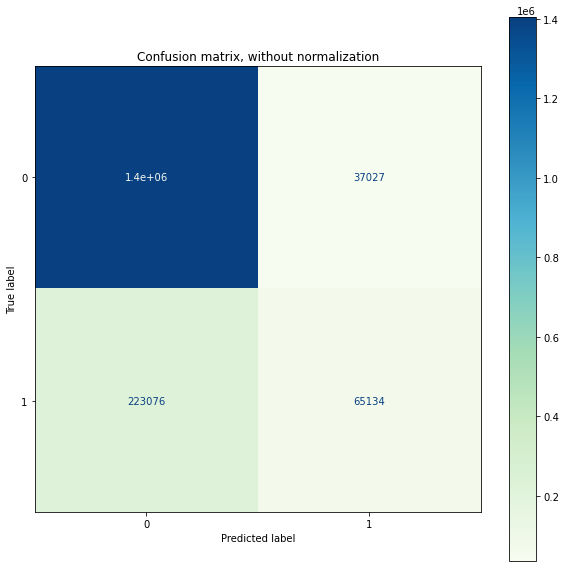

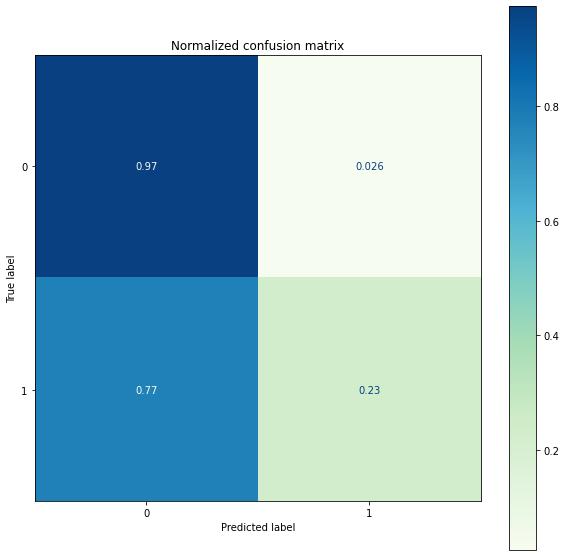

In [14]:
# Matrices de confusiones
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, CV_predictions,
                                                       cmap=plt.cm.GnBu,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

#### Curvas ROC-AUC

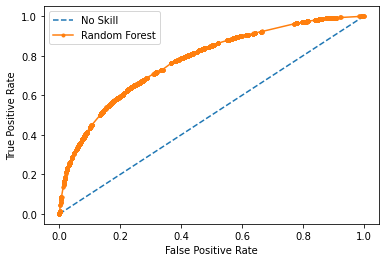

In [15]:
# keep probabilities for the positive outcome only
yhat = CV_predict_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [16]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [17]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.166571, G-Mean=0.701


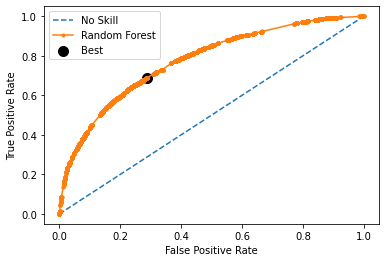

In [18]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [19]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

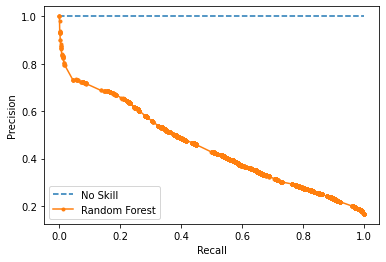

In [20]:
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.234818, F-Score=0.466


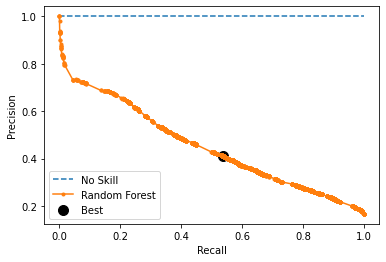

In [21]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [22]:
# evaluate the model
score = f1_score(y_test, CV_predictions)
print('F-Score: %.5f' % score)

F-Score: 0.33370


In [23]:
evaluate_model(y_test, CV_predictions, CV_predict_proba)

ROC-AUC score of the model: 0.7754088561175787
Accuracy of the model: 0.8495237577319945

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.97      0.92   1440322
           1       0.64      0.23      0.33    288210

    accuracy                           0.85   1728532
   macro avg       0.75      0.60      0.62   1728532
weighted avg       0.83      0.85      0.82   1728532


Confusion matrix: 
[[1403295   37027]
 [ 223076   65134]]



### Guardamos el modelo

In [33]:
with open('CV_Randomforest.pkl', 'wb') as f:
    pickle.dump(CV, f)